In [1]:
from MALDIMap import MALDINet
from MALDIMap.utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import gc
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='5'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

### Data_4 全质谱测试

In [3]:
mp = load('/raid/lzyt_dir/Test_MS_all/Data4/agg_fit.mp')

In [4]:
mp.plot_grid(enabled_data_labels=False)

2024-01-26 10:50:27,181 - INFO - [bidd-aggmap] - generate file: ./feature points_30748_euclidean_umap_mp
2024-01-26 10:50:27,579 - INFO - [bidd-aggmap] - save html file to ./feature points_30748_euclidean_umap_mp


In [5]:
data1 = pd.read_csv(r'/raid/lzyt_dir/Data_ms_all/data4/ms_all.csv',header = None)
dfx = pd.DataFrame(data1)                                         
dfx = dfx.drop(dfx.index[0])                                      #原核质比行可以清除
dfx.index = list(range(len(dfx)))                                 #行索引重新编号
dfx = pd.DataFrame(dfx).T                                         #需转置

feas = list(dfx.iloc[0])                                          #提取第一行核质比信息
feas = list(map(lambda x:str(x),feas))                            #特征只能是整数或字符串
dfx = dfx.drop(dfx.index[0])                                      #原核质比行可以清除
dfx.index = list(range(len(dfx)))                                 #行索引重新编号
dfx.columns = feas                                                #特征值存为列名
dfx = dfx.astype(float)                                          #数据格式转换非常重要
dfx

998.4205305817171  998.6313389663279  998.859799640446  \
0                   NaN                NaN               NaN   
1                   NaN                NaN               NaN   
2                   NaN                NaN               NaN   
3                   NaN                NaN               NaN   
4                   NaN                NaN               NaN   
...                 ...                ...               ...   
1249                NaN              817.0             712.0   
1250                NaN             1198.0            1115.0   
1251                NaN             1385.0            1285.0   
1252                NaN             2517.0            2332.0   
1253                NaN             2068.0            2003.0   

      999.082089036344  999.31259636586  999.56479121956  999.803937693942  \
0                  NaN              NaN           1180.0            1256.0   
1                  NaN              NaN           1295.0            1167.0   
2                  NaN              NaN            542.0             572.0   
3                  NaN              NaN            839.0             870.0   
4                  NaN              NaN           1037.0             965.0   
...                ...              ...              ...               ...   
1249             783.0            733.0            702.0             695.0   
1250            1242.0           1192.0           1182.0            1057.0   
1251            1245.0           1272.0           1300.0            1296.0   
1252            2311.0           2516.0           2350.0            2315.0   
1253            2205.0           2073.0           2038.0            2144.0   

      1000.00547666591  1000.2316689848801  1000.45521669819  ...  \
0               1258.0              1186.0            1111.0  ...   
1               1134.0              1163.0            1081.0  ...   
2                491.0               432.0             514.0  ...   
3                817.0               908.0             924.0  ...   
4                991.0               951.0             966.0  ...   
...                ...                 ...               ...  ...   
1249             601.0               628.0             579.0  ...   
1250            1061.0              1211.0            1225.0  ...   
1251            1227.0              1252.0            1299.0  ...   
1252            2438.0              2282.0            2191.0  ...   
1253            2153.0              2133.0            2189.0  ...   

      20027.77786197  20028.8032736168  20029.8287119773  20030.8541770516  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4                NaN               NaN               NaN               NaN   
...              ...               ...               ...               ...   
1249             NaN               NaN               NaN               NaN   
1250             NaN               NaN               NaN               NaN   
1251             NaN               NaN               NaN               NaN   
1252             NaN               NaN               NaN               NaN   
1253             NaN               NaN               NaN               NaN   

      20031.8796688397  20032.905187341697  20033.9307325576  \
0                  NaN                 NaN               NaN   
1                  NaN                 NaN               NaN   
2                  NaN                 NaN               NaN   
3                  NaN                 NaN               NaN   
4                  NaN                 NaN               NaN   
...                ...                 ...               ...   
1249               NaN                 NaN               NaN   
1250               NaN

In [6]:
Y = np.zeros((1254,2))                                            #将标签以独热编码存起来 1254例
for i in range (0,456):                                           #阳性456例
    Y[i,1] = 1                                                    #阳性标签为1
for i in range (456,1254):                                        #阴性798例
    Y[i,0] = 1                                                    #阴性标签为0
    
y = Y.astype(int)

Y = np.zeros(1254)                                                 #用于分层的标签
for i in range (0,456):                                           #阳性456例
    Y[i] = 1                                                      #阳性标签为1
for i in range (456,1254):                                         #阴性798例
    Y[i] = 0                                                       #阴性标签为0
Y = Y.astype(int)

In [7]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 1254/1254 [10:37<00:00,  1.97it/s]


Auc =  0.9859857806945583
Acc =  0.9880478087649402
f1_score =  0.9880478087649402
average_precision =  0.9880478087649402
recall_score =  0.9880478087649402


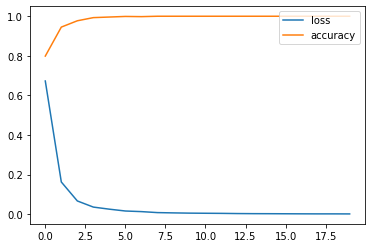

Auc =  0.9968750000000001
Acc =  0.9960159362549801
f1_score =  0.9960159362549801
average_precision =  0.9960159362549801
recall_score =  0.9960159362549801


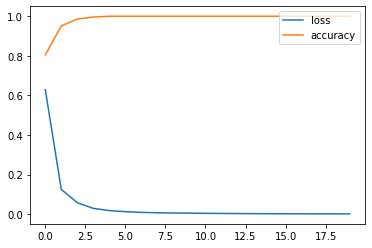

Auc =  0.9945054945054945
Acc =  0.9960159362549801
f1_score =  0.9960159362549801
average_precision =  0.9960159362549801
recall_score =  0.9960159362549801


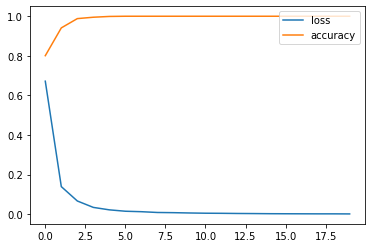

Auc =  0.989010989010989
Acc =  0.9920318725099602
f1_score =  0.99203187250996
average_precision =  0.9920318725099602
recall_score =  0.9920318725099602


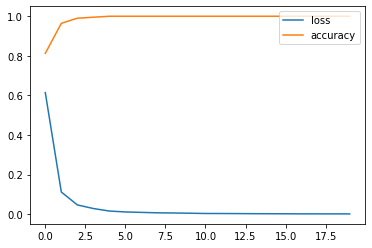

Auc =  0.9937106918238994
Acc =  0.992
f1_score =  0.992
average_precision =  0.992
recall_score =  0.992


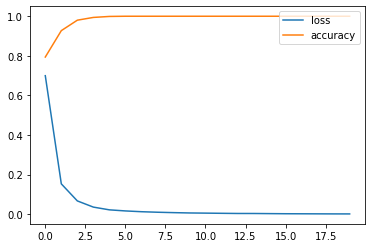

0.9928223107569721

In [10]:
#三核 四折交叉验证最佳结果
outer = RepeatedStratifiedKFold(n_splits = 5,n_repeats=1,random_state=2652124)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=64,epochs=20,gpuid=5)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 5

In [16]:
print(mp.flist)

['998.4205305817171', '998.6313389663279', '998.859799640446', '999.082089036344', '999.31259636586', '999.56479121956', '999.803937693942', '1000.00547666591', '1000.2316689848801', '1000.45521669819', '1000.69238099074', '1000.9186192085001', '1001.1436903519699', '1001.3726588686699', '1001.5989452399301', '1001.8252572568699', '1002.05159491952', '1002.27795822789', '1002.5043471820301', '1002.7296721032401', '1002.9561098187199', '1003.18257317997', '1003.40906218703', '1003.6355768399198', '1003.8621171386699', '1004.0886830833099', '1004.3152746738699', '1004.5418919103698', '1004.76853479285', '1004.9952033213199', '1005.2218974958198', '1005.4486173163699', '1005.67536278301', '1005.90213389575', '1006.12893065464', '1006.3557530596801', '1006.58260111092', '1006.8094748083901', '1007.0363741521', '1007.2632991420801', '1007.49024977837', '1007.71722606099', '1007.9442279899699', '1008.1712555653301', '1008.39830878711', '1008.6253876553301', '1008.85249217002', '1009.07962233

In [15]:
mp.df_grid

x    y                   v    Subtypes   colors
0        0    0  2833.8976469211498  cluster_04  #00ff5c
1        1    0  2833.5161836474394  cluster_04  #00ff5c
2        2    0    2824.44109941399  cluster_04  #00ff5c
3        3    0  2832.3719487063204  cluster_04  #00ff5c
4        4    0    2824.06027656594  cluster_04  #00ff5c
...    ...  ...                 ...         ...      ...
30795  170  175           NaN-30795         NaN  #000000
30796  171  175           NaN-30796         NaN  #000000
30797  172  175           NaN-30797         NaN  #000000
30798  173  175           NaN-30798         NaN  #000000
30799  174  175           NaN-30799         NaN  #000000

[30800 rows x 5 columns]

In [17]:
mp2 = load('/mnt/lzyt/SmallSamples/data4/aggmap/aggmap_peaks_0.8.mp')

In [18]:
mp2.flist

['1327.71567933259',
 '1521.45799092981',
 '1618.42996674844',
 '1864.6004164688',
 '1896.5940044767199',
 '1943.7194404079603',
 '1967.15059140496',
 '2044.76955530295',
 '2068.7169230437303',
 '2081.49179250897',
 '2092.02336843341',
 '2104.3808085704',
 '2209.4281073754896',
 '2307.8343473193',
 '2466.4532308610997',
 '2553.31116886989',
 '2660.40138981093',
 '2671.13399382775',
 '2707.4529153495',
 '2740.26414839575',
 '2859.4976427472498',
 '2883.33594115678',
 '2900.4433888981',
 '2915.43135712745',
 '2952.4894401688002',
 '2991.16959070031',
 '3045.21919284695',
 '3065.83307187209',
 '3095.61437176278',
 '3143.44572822188',
 '3241.12120401945',
 '3275.5710489244602',
 '3315.4297324489803',
 '3507.3639808662397',
 '3524.9623831590297',
 '3642.78855004769',
 '3734.78303305709',
 '3814.3561116315705',
 '3882.97628877039',
 '3935.52816144053',
 '3957.9116240749104',
 '4091.73951364198',
 '4153.70030567833',
 '4210.06379376485',
 '4283.659012132151',
 '4299.38359629285',
 '4339.01213

In [20]:
peaks = ['1327','1464','1625','1815','2270','2660','3066','3315','3508','4153','4715','5372',
        '6376','7467','7802','8124','8762','12606','18584']
df = mp.df_grid

In [23]:
# 存储满足条件的特征坐标
coordinates = []

# 遍历known_features中的每个数字
for feature in peaks:
    # 将特征名称转换为浮点数
    feature_float = float(feature)
    
    # 遍历DataFrame的每一行
    for index, row in df.iterrows():
        try:
            row_feature_float = float(row['v'])
        except ValueError:
            continue
        diff = abs(row_feature_float - feature_float)
        if diff < 1:
            coordinates.append((row['x'], row['y']))

# 打印结果
print(coordinates)

[(85, 132), (84, 133), (84, 134), (86, 138), (85, 139), (86, 139), (86, 140), (86, 141), (120, 128), (119, 129), (118, 130), (117, 131), (118, 131), (116, 132), (117, 132), (117, 147), (116, 148), (118, 148), (116, 149), (116, 150), (115, 151), (114, 153), (136, 167), (133, 170), (131, 171), (133, 171), (128, 173), (129, 173), (127, 174), (135, 128), (130, 129), (130, 130), (131, 130), (132, 130), (130, 131), (127, 0), (128, 0), (129, 0), (126, 1), (127, 1), (128, 1), (39, 11), (39, 12), (41, 12), (42, 12), (41, 13), (26, 26), (26, 27), (26, 29), (27, 30), (27, 31), (134, 11), (137, 13), (138, 13), (138, 14), (137, 15), (170, 10), (170, 11), (168, 12), (167, 13), (166, 15), (148, 146), (148, 147), (148, 149), (148, 151), (79, 66), (78, 67), (79, 68), (81, 68), (57, 12), (58, 12), (58, 13), (57, 15), (122, 41), (123, 41), (123, 42), (144, 31), (143, 33), (143, 34), (158, 95), (159, 95), (158, 96), (159, 96), (167, 129), (169, 133), (169, 135), (105, 109), (103, 111), (9, 63), (13, 63)]


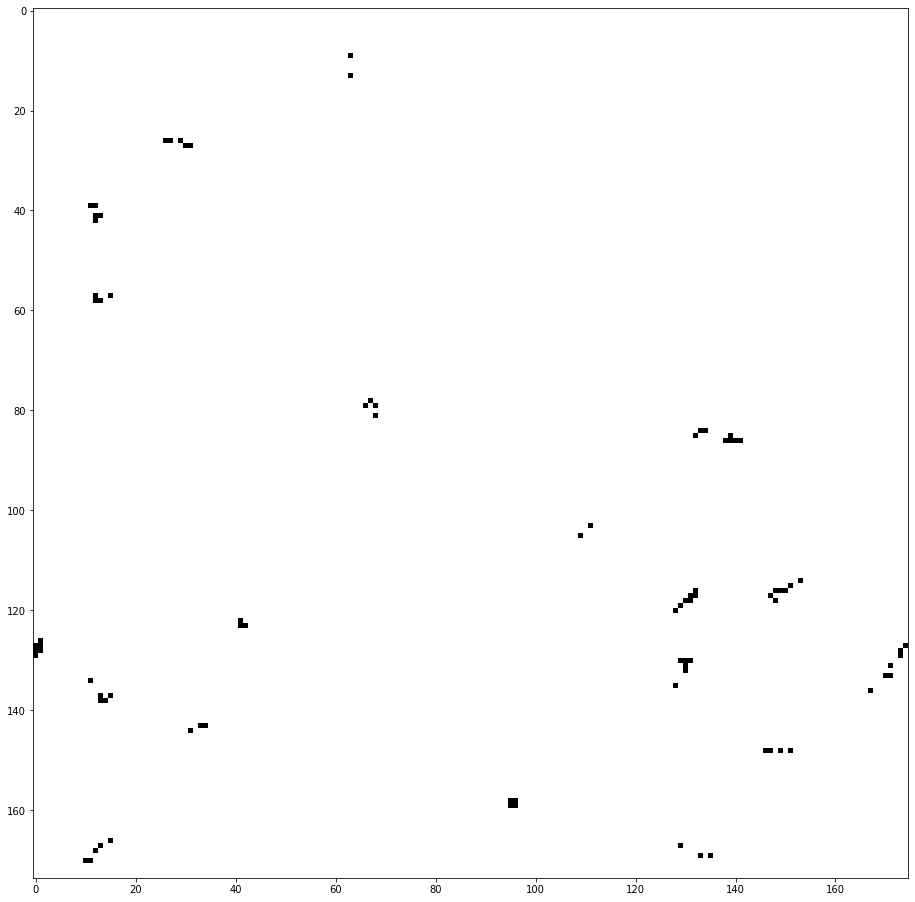

In [37]:
from matplotlib.colors import ListedColormap

custom_colors = ['#FF0000', '#000000']  # 自定义颜色值列表，以黑色和红色为例
cmap = ListedColormap(custom_colors)

n = 174
m = 175

# 创建一个大小为n*m的格点图
grid = np.zeros((n, m))

# 已知特征坐标列表coordinates

# 根据特征坐标标记格点
for coordinate in coordinates:
    x, y = coordinate
    if x < n and y < m:
        grid[x][y] = 1  # 可以根据需要设置不同的值来标记不同颜色

# 设置图像大小
plt.figure(figsize=(16, 16))  # 设置宽度为8，高度为6

# 绘制格点图
plt.imshow(grid, cmap='gist_yarg')

# 设置横轴和纵轴的刻度间隔
plt.xticks(np.arange(0, n, 20), np.arange(0, n, 20))
plt.yticks(np.arange(0, m, 20), np.arange(0, m, 20))


# 显示图形
plt.show()

In [38]:
# 存储满足条件的特征坐标
zb = []

# 遍历known_features中的每个数字
for feature in mp2.flist:
    # 将特征名称转换为浮点数
    feature_float = float(feature)
    
    # 遍历DataFrame的每一行
    for index, row in df.iterrows():
        try:
            row_feature_float = float(row['v'])
            diff = abs(row_feature_float - feature_float)
            if diff < 1:
                zb.append((row['x'], row['y']))
        except ValueError:
            continue
# 打印结果
print(zb)

[(85, 133), (84, 134), (85, 135), (85, 136), (85, 139), (86, 139), (86, 140), (86, 141), (128, 125), (126, 126), (127, 126), (128, 126), (129, 126), (129, 127), (129, 128), (111, 148), (112, 148), (112, 149), (111, 150), (113, 151), (111, 153), (112, 154), (138, 149), (145, 151), (145, 152), (147, 152), (147, 153), (148, 153), (149, 154), (147, 158), (147, 159), (148, 159), (145, 160), (146, 160), (147, 160), (147, 164), (63, 82), (134, 161), (136, 161), (135, 162), (137, 163), (139, 165), (138, 166), (148, 161), (148, 163), (146, 164), (148, 165), (149, 165), (149, 166), (155, 139), (150, 140), (151, 140), (152, 140), (153, 140), (155, 140), (152, 127), (151, 128), (152, 128), (149, 129), (152, 129), (151, 130), (151, 105), (148, 106), (149, 106), (150, 106), (151, 106), (152, 106), (148, 108), (151, 119), (152, 119), (150, 120), (153, 120), (149, 121), (151, 123), (151, 110), (153, 110), (149, 113), (151, 114), (148, 115), (150, 116), (138, 129), (139, 129), (139, 130), (140, 131), (

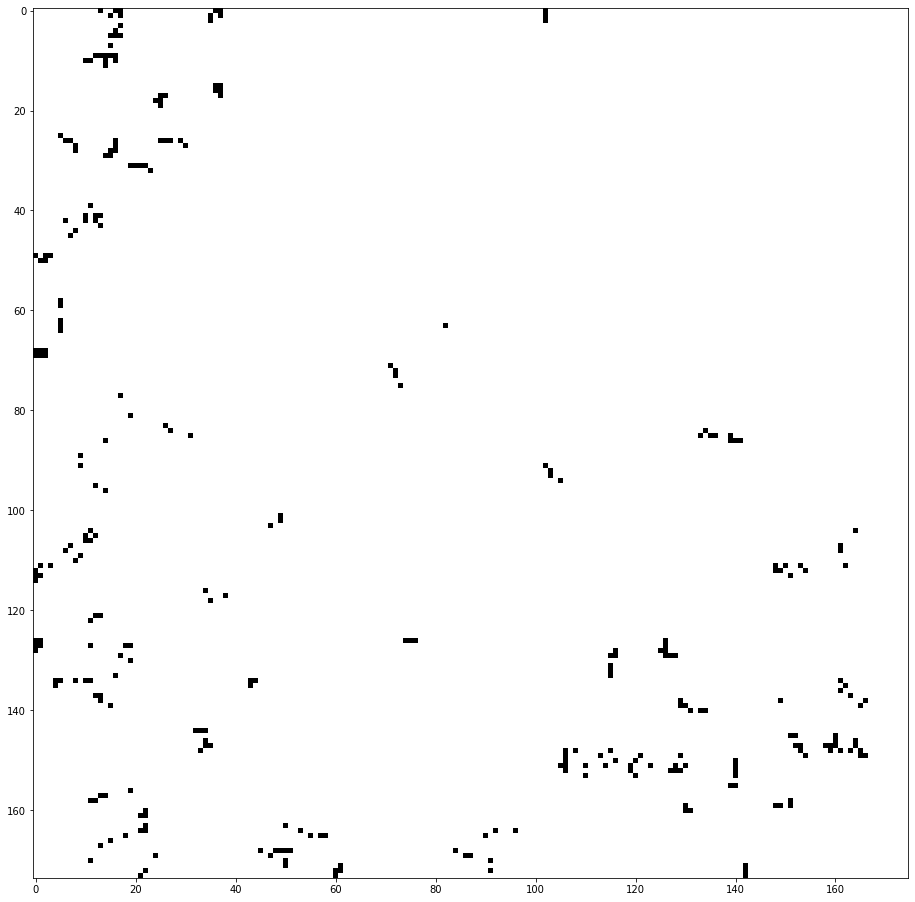

In [39]:
from matplotlib.colors import ListedColormap

custom_colors = ['#FF0000', '#000000']  # 自定义颜色值列表，以黑色和红色为例
cmap = ListedColormap(custom_colors)

n = 174
m = 175

# 创建一个大小为n*m的格点图
grid = np.zeros((n, m))

# 已知特征坐标列表coordinates

# 根据特征坐标标记格点
for coordinate in zb:
    x, y = coordinate
    if x < n and y < m:
        grid[x][y] = 1  # 可以根据需要设置不同的值来标记不同颜色

# 设置图像大小
plt.figure(figsize=(16, 16))  # 设置宽度为8，高度为6

# 绘制格点图
plt.imshow(grid, cmap='gist_yarg')

# 设置横轴和纵轴的刻度间隔
plt.xticks(np.arange(0, n, 20), np.arange(0, n, 20))
plt.yticks(np.arange(0, m, 20), np.arange(0, m, 20))


# 显示图形
plt.show()

In [41]:
import pickle

# 打开 .pkl 文件
with open('HIP_CER.pkl', 'rb') as f:
    data = pickle.load(f)

# 读取数据
print(data)

                   54.1983  56.1029   56.5342  56.6536   56.7016  58.7696  \
x_10020y_24575.d  0.000000      0.0  0.000000      0.0  0.000000      0.0   
x_10192y_5819.d   0.000000      0.0  0.000000      0.0  0.000000      0.0   
x_10348y_24164.d  0.007193      0.0  0.024173      0.0  0.005693      0.0   
x_10673y_24096.d  0.000000      0.0  0.000000      0.0  0.000000      0.0   
x_10683y_25227.d  0.007479      0.0  0.028056      0.0  0.004818      0.0   
...                    ...      ...       ...      ...       ...      ...   
x_97841y_27975.d  0.000000      0.0  0.000000      0.0  0.000000      0.0   
x_97986y_25658.d  0.000000      0.0  0.000000      0.0  0.000000      0.0   
x_98103y_10165.d  0.000000      0.0  0.000000      0.0  0.000000      0.0   
x_98160y_9196.d   0.000000      0.0  0.000000      0.0  0.000000      0.0   
x_98218y_25962.d  0.000000      0.0  0.000000      0.0  0.000000      0.0   

                  59.0109  59.2733  59.4318  59.5242  ...  499.1488  499.16